<a href="https://colab.research.google.com/github/bhaktichavanke/Email-Bot/blob/main/Project_Phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1 — Install Libraries**

In [1]:
!pip install -q timm albumentations scikit-learn seaborn

# **Step 2 — Imports & Device**

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import timm
import numpy as np
import os
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# **Step 3 — Get Dataset**

**1. Upload API Key**

In [5]:
from google.colab import files
files.upload()   # upload kaggle.json

Saving kaggle (2).json to kaggle (2) (1).json


{'kaggle (2) (1).json': b'{"username":"arunkumarjnv","key":"efe37b675a328161def7df7ae826b726"}'}

**2. Configure Kaggle**

In [7]:
!mkdir -p ~/.kaggle
!cp "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

**3. Test**

In [8]:
!kaggle datasets list

ref                                                             title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                             Chocolate Sales                                       468320  2026-01-04 14:23:35.490000          16224        291  1.0              
aliiihussain/amazon-sales-dataset                               Amazon_Sales_Dataset                                 1297759  2026-02-01 11:37:12.353000           2959         54  1.0              
hassanjameelahmed/price-of-healthy-diet-clean                   Global Healthy Diet Cost Analysis (2017–2024)          14103  2026-02-05 07:18:40.347000            473         21  1.0              
ibrahimsha

**4. Download Plant Dataset**

In [9]:
!kaggle datasets download -d warcoder/indian-medicinal-plant-image-dataset

Dataset URL: https://www.kaggle.com/datasets/warcoder/indian-medicinal-plant-image-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 60% 151M/253M [00:00<00:00, 1.58GB/s]
100% 253M/253M [00:00<00:00, 958MB/s] 


**5. Unzip**

In [10]:
!unzip -o indian-medicinal-plant-image-dataset.zip -d plant_data

Streaming output truncated to the last 5000 lines.
  inflating: plant_data/Medicinal plant dataset/Avacado/5611.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5612.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5613.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5614.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5615.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5616.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5617.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5618.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5619.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5620.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5621.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5622.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5623.jpg  
  inflating: plant_data/Medicinal plant dataset/Avacado/5624.jpg  
  inflating

In [11]:
!ls plant_data

'Medicinal plant dataset'


# **Step 4 — Image Transforms**

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tfms = A.Compose([
    A.Resize(224,224),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(),
    ToTensorV2()
])


#**Step 5 — Dataset Class**

In [13]:
class PlantDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = sorted(os.listdir(root))
        self.paths = []
        self.labels = []

        for i,c in enumerate(self.classes):
            for img in os.listdir(os.path.join(root,c)):
                self.paths.append(os.path.join(root,c,img))
                self.labels.append(i)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, self.labels[idx]


#**Step 6 — Train / Val Split**

In [14]:
dataset = PlantDataset("plant_data/Medicinal plant dataset", train_tfms)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

val_ds.dataset.transform = val_tfms

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

num_classes = len(dataset.classes)
print(num_classes)


40


# **Step 7 — Evaluation Function**

In [15]:
def evaluate(model):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x,y in val_loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y)

    acc = accuracy_score(y_true,y_pred)
    prec = precision_score(y_true,y_pred,average='weighted')
    rec = recall_score(y_true,y_pred,average='weighted')
    f1 = f1_score(y_true,y_pred,average='weighted')
    cm = confusion_matrix(y_true,y_pred)

    return acc,prec,rec,f1,cm


#**Step 8 — Model Loader**

In [16]:
def get_model(name):
    model = timm.create_model(name, pretrained=True)
    if "vit" in name:
        model.head = nn.Linear(model.head.in_features, num_classes)
    else:
        model.reset_classifier(num_classes)
    return model.to(device)


#**Step 9 — Compare Models**

In [17]:
models = ["resnet50","efficientnet_b3","vit_base_patch32_224"]
results = {}

for m in models:
    model = get_model(m)
    acc,prec,rec,f1,cm = evaluate(model)
    results[m] = [acc,prec,rec,f1]
    print(m, acc, prec, rec, f1)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


resnet50 0.017661900756938603 0.007259551207329542 0.017661900756938603 0.006428856217405276


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


efficientnet_b3 0.01934398654331371 0.014804668318839774 0.01934398654331371 0.014612296868774714


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

vit_base_patch32_224 0.021867115222876366 0.01682413891652482 0.021867115222876366 0.017268697644648317


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Step 10 — Model Training for Evaluation Metrics**

**1. Training Function**

In [19]:
def train_model(model, epochs=2):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1} Loss:", total_loss/len(train_loader))


**2. Loop for All 3 Models**

In [20]:
models = {
    "resnet50": "resnet50",
    "efficientnet_b3": "efficientnet_b3",
    "vit_base_patch32_224": "vit_base_patch32_224"
}

results = {}

for name, timm_name in models.items():
    print(f"\nTraining {name}...")

    model = get_model(timm_name)
    train_model(model, epochs=5)   # increase to 5 later if needed

    acc, prec, rec, f1, cm = evaluate(model)

    results[name] = [acc, prec, rec, f1]

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)



Training resnet50...
Epoch 1 Loss: 3.4498935841873988
Epoch 2 Loss: 1.877405270434066
Accuracy: 0.8393608074011775
Precision: 0.8570599752421617
Recall: 0.8393608074011775
F1: 0.829488289567466

Training efficientnet_b3...
Epoch 1 Loss: 2.1662688633339515
Epoch 2 Loss: 0.3127607961604059
Accuracy: 0.9764507989907485
Precision: 0.9780930097653285
Recall: 0.9764507989907485
F1: 0.97635304336432

Training vit_base_patch32_224...
Epoch 1 Loss: 0.6437186520677936
Epoch 2 Loss: 0.030819173773747537
Accuracy: 0.975609756097561
Precision: 0.9776368511140212
Recall: 0.975609756097561
F1: 0.9754553751935192


#**Step 10.2 — Model Training for Evaluation Metrics with Hyperparameter Tuning**




**1. Model Loader**

In [26]:
import timm
import torch.nn as nn

def get_model(name, num_classes):
    model = timm.create_model(name, pretrained=True)

    if "vit" in name:
        model.head = nn.Linear(model.head.in_features, num_classes)
    else:
        model.reset_classifier(num_classes)

    return model.to(device)


**2. Phase-1 Training Function (Freeze)**

In [31]:
def train_phase1(model, epochs=3):

    # Freeze all first
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze classifier only
    if hasattr(model, "head"):          # ViT
        for param in model.head.parameters():
            param.requires_grad = True
        train_params = model.head.parameters()

    else:                               # ResNet / EfficientNet
        for param in model.get_classifier().parameters():
            param.requires_grad = True
        train_params = model.get_classifier().parameters()

    optimizer = torch.optim.Adam(train_params, lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for e in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()


**3. Phase-2 Training Function (Unfreeze)**

In [32]:
def train_phase2(model, epochs=5):
    for param in model.parameters():
        param.requires_grad = True

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    for e in range(epochs):
        model.train()
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out,y)
            loss.backward()
            optimizer.step()


**4. Run for All 3 Models**

In [33]:
models = ["resnet50", "efficientnet_b3", "vit_base_patch32_224"]
results = {}

for m in models:
    print("\nTraining", m)

    model = get_model(m, num_classes)

    train_phase1(model)   # freeze backbone
    train_phase2(model)   # unfreeze all

    acc, prec, rec, f1, cm = evaluate(model)
    results[m] = [acc, prec, rec, f1]

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)




Training resnet50
Accuracy: 0.9529015979814971
Precision: 0.9542155849511718
Recall: 0.9529015979814971
F1: 0.9525947400719814

Training efficientnet_b3
Accuracy: 0.9747687132043734
Precision: 0.9754958944992548
Recall: 0.9747687132043734
F1: 0.9747803777391347

Training vit_base_patch32_224
Accuracy: 0.9789739276703112
Precision: 0.9799306456181129
Recall: 0.9789739276703112
F1: 0.9789252911610103


#**Step 11 — Results Table**

In [34]:
import pandas as pd
pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1"]).T

,Accuracy,Precision,Recall,F1
resnet50,0.952902,0.954216,0.952902,0.952595
efficientnet_b3,0.974769,0.975496,0.974769,0.974780
vit_base_patch32_224,0.978974,0.979931,0.978974,0.978925


#**Step 12 — Confusion Matrix**

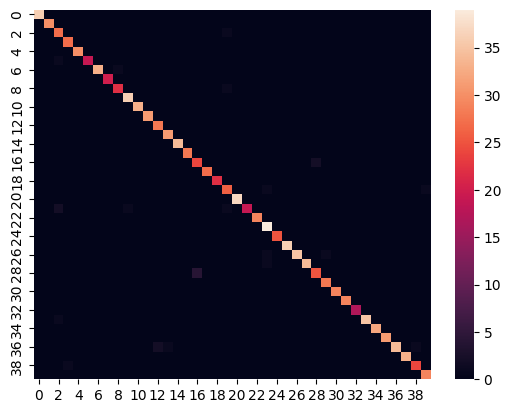

In [37]:
sns.heatmap(cm)
plt.show()